In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
MAX_EPOCHS = 15
DATA_DIR = "/Users/omgoswami/Downloads/split/ALL"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")
class_names = ["all_benign","all_early","all_pre","all_pro"]
class_details = ["all_benign","all_early","all_pre","all_pro"]

datagen = ImageDataGenerator(preprocessing_function=lambda img: img,
                             horizontal_flip=True)

train_gen = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

valid_gen = datagen.flow_from_directory(VAL_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE)

test_gen = datagen.flow_from_directory(TEST_DIR,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        classes=class_names,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

Found 14000 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.
Found 3000 images belonging to 4 classes.


In [3]:
def print_image_count(dataset, dataset_name):
    num_images = len(dataset) * BATCH_SIZE
    print(f"Number of images in {dataset_name} dataset: {num_images}")

print_image_count(train_gen, "train")
print_image_count(valid_gen, "validation")
print_image_count(test_gen, "test")

Number of images in train dataset: 14000
Number of images in validation dataset: 3008
Number of images in test dataset: 3008


In [4]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB7(
    include_top=False, weights="imagenet", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), pooling="max"
)
pretrained_efficientnet_base.trainable = False

efficentNet_model = tf.keras.Sequential([
    pretrained_efficientnet_base,
    layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l=0.016),
                 activity_regularizer=tf.keras.regularizers.l1(0.006),
                 bias_regularizer=tf.keras.regularizers.l1(0.006), activation='relu'),
    layers.Dropout(rate=0.45, seed=123),
    layers.Dense(len(class_names), activation='softmax')
])

efficentNet_model.compile(tf.keras.optimizers.Adamax(learning_rate=0.001),
                          loss='categorical_crossentropy', metrics=['accuracy'])

efficentNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 batch_normalization (BatchN  (None, 2560)             10240     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 64,764,571
Trainable params: 661,764
Non-trainable params: 64,102,807
______________________________________

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=0.001,
                              mode='min')

# Train the model
history = efficentNet_model.fit(x=train_gen,
                                epochs=MAX_EPOCHS,
                                verbose=1,
                                validation_data=valid_gen,
                                validation_steps=None,
                                shuffle=False,
                                batch_size=BATCH_SIZE,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/10


2024-03-11 18:09:32.631241: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


875/875 [==============================] - 801s 904ms/step - loss: 5.7996 - accuracy: 0.8297 - val_loss: 2.9719 - val_accuracy: 0.9503 - lr: 0.0010
Epoch 2/10
875/875 [==============================] - 1048s 1s/step - loss: 2.1531 - accuracy: 0.9063 - val_loss: 1.4752 - val_accuracy: 0.9597 - lr: 0.0010
Epoch 3/10
875/875 [==============================] - 998s 1s/step - loss: 1.4292 - accuracy: 0.9084 - val_loss: 1.2491 - val_accuracy: 0.9520 - lr: 0.0010
Epoch 4/10
875/875 [==============================] - 996s 1s/step - loss: 1.3044 - accuracy: 0.9106 - val_loss: 1.2192 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 5/10
875/875 [==============================] - 1012s 1s/step - loss: 1.2944 - accuracy: 0.9111 - val_loss: 1.2051 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 6/10
875/875 [==============================] - 978s 1s/step - loss: 1.3153 - accuracy: 0.9108 - val_loss: 1.2219 - val_accuracy: 0.9573 - lr: 0.0010
Epoch 7/10
875/875 [==============================] - 945s 1s/step - l

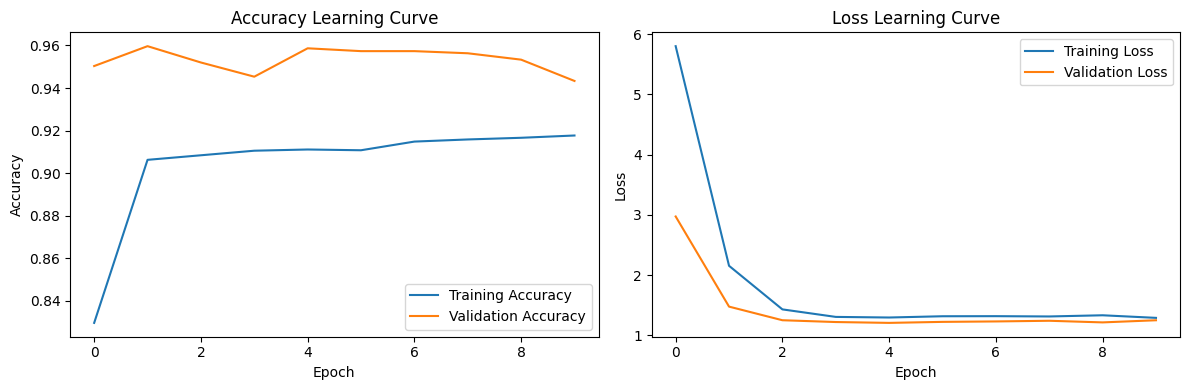

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report

test_loss, test_accuracy = efficentNet_model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

188/188 [==============================] - 136s 725ms/step - loss: 1.2428 - accuracy: 0.9470
Test Accuracy: 94.70%


In [8]:
predictions = efficentNet_model.predict(test_gen)
true_labels = test_gen.classes
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

188/188 [==============================] - 144s 735ms/step
Confusion Matrix:
[[650  71  14  15]
 [  6 726  10   8]
 [  0  14 712  24]
 [  0   1   1 748]]

Classification Report:
              precision    recall  f1-score   support

  all_benign       0.99      0.87      0.92       750
   all_early       0.89      0.97      0.93       750
     all_pre       0.97      0.95      0.96       750
     all_pro       0.94      1.00      0.97       750

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



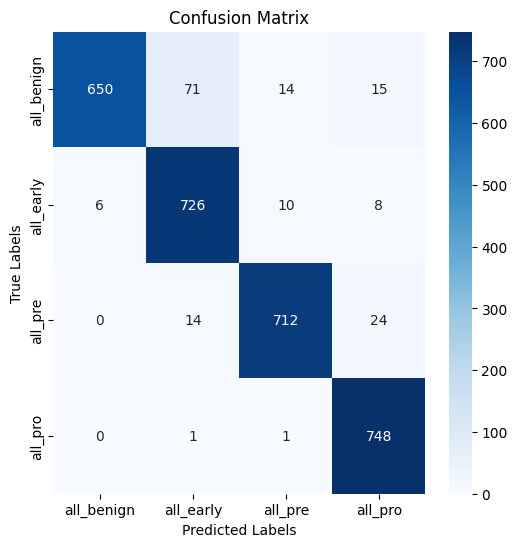

In [9]:
import seaborn as sns
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(conf_matrix, class_names)

188/188 [==============================] - 134s 711ms/step


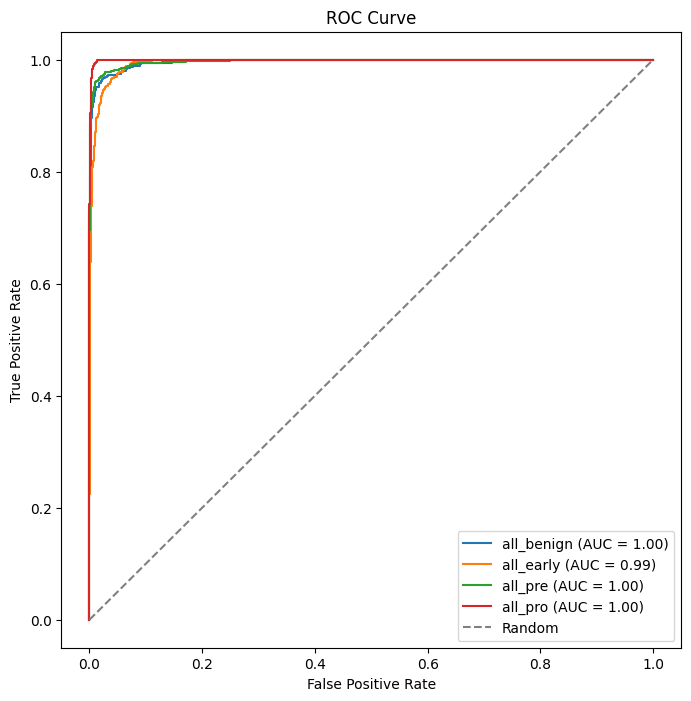

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, class_labels):
    plt.figure(figsize=(8, 8))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

y_prob = efficentNet_model.predict(test_gen)
y_true = test_gen.classes

y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

plot_roc_curve(y_true_one_hot, y_prob, class_names)